This notebook tries to apply LASER sentence embeddings (as the only known sentence embeddings for Bashkir) to validation data and see how their cosine similarity correlates with human labels:

* ROC AUC of 75%
* Recall @ idealistic of 48%

Which means: LASER sucks for this languag pair (at least, without margin scores). 

# 1. Learn to run LASER2/3 embeddings

https://github.com/facebookresearch/LASER

```
wget --trust-server-names -q https://tinyurl.com/nllblaser2
wget --trust-server-names -q https://dl.fbaipublicfiles.com/nllb/laser/laser2.spm
wget --trust-server-names -q https://dl.fbaipublicfiles.com/nllb/laser/laser2.cvocab
wget --trust-server-names -q https://dl.fbaipublicfiles.com/nllb/laser/laser3-bak_Cyrl.v1.pt
wget --trust-server-names -q https://dl.fbaipublicfiles.com/nllb/laser/laser3-bak_Cyrl.v1.spm
wget --trust-server-names -q https://dl.fbaipublicfiles.com/nllb/laser/laser3-bak_Cyrl.v1.cvocab
```

`pip install fairseq==0.12.1` (it throws an error `No such file or directory: 'fairseq\\version.txt'`, but this is fine)

```
python3 ${LASER}/source/embed.py \
    --input     ${infile}        \
    --encoder   ${model_file}    \
    --spm-model $spm             \
    --output    ${outfile}       \
    --verbose
```

In [2]:
LASER_CODE_DIR = 'C:/Users/david/YandexDisk/code/NLP/LASER'
LASER_MODELS_DIR = 'C:/Users/david/Documents/nlp/laser3'

In [3]:
import os
import sys

In [4]:
def add_sys_path(p):
    p = os.path.abspath(p)
    assert os.path.exists(p)
    if p not in sys.path:
        sys.path.append(p)

add_sys_path(LASER_CODE_DIR + '/source')

In [14]:
USE_CUDA = True
# os.environ['CUDA_VISIBLE_DEVICES'] = '' 
# because my CUDA is currently used by another process, but LASER still tries to use it under the hood

In [8]:
os.environ['LASER'] = LASER_CODE_DIR

In [9]:
from embed import LaserTransformerEncoder, load_model

In [15]:
encoder_ru = load_model(
    LASER_MODELS_DIR + '/laser2.pt', 
    LASER_MODELS_DIR + '/laser2.spm', 
    LASER_MODELS_DIR + '/laser2.cvocab',
    cpu=not USE_CUDA,
)

In [11]:
import sentencepiece as spm

In [12]:
ru_tokenizer = spm.SentencePieceProcessor()
ru_tokenizer.Load(LASER_MODELS_DIR + '/laser2.spm')

True

In [16]:
encoder_ba = load_model(
    LASER_MODELS_DIR + '/laser3-bak_Cyrl.v1.pt', 
    LASER_MODELS_DIR + '/laser3-bak_Cyrl.v1.spm', 
    LASER_MODELS_DIR + '/laser3-bak_Cyrl.v1.cvocab',
    cpu=not USE_CUDA,
)

In [17]:
ba_tokenizer = spm.SentencePieceProcessor()
ba_tokenizer.Load(LASER_MODELS_DIR + '/laser3-bak_Cyrl.v1.spm')

True

In [18]:
import torch

def embed(texts, model, tokenizer, normalize=True):
    texts_tok = [
        ' '.join(tokenizer.encode_as_pieces(text))
        for text in texts
    ]
    with torch.inference_mode():
        emb = model.encode_sentences(texts_tok)
    if normalize:
        emb = emb / (emb**2).sum(1, keepdims=True) ** 0.5
    return emb

In [19]:
ru_sents = ['привет мир!', 'привет, как дела?', 'Мама мыла раму']
en_sents = ['Hello world!', 'Hi, how are you?', 'Mom was washing the frame']
ba_sents = ['сәләм тыныслыҡ!', 'сәләм, хәлдәр нисек?', 'Әсәй рамаҙан айы']

In [20]:
%%time

b_ru = embed(ru_sents, encoder_ru, ru_tokenizer)
b_en = embed(en_sents, encoder_ru, ru_tokenizer)

Wall time: 653 ms


In [21]:
%%time

b_ba = embed(ba_sents, encoder_ba, ba_tokenizer)

Wall time: 62 ms


In [22]:
b_ru.dot(b_ru.T)

array([[0.9999999 , 0.61413217, 0.30851567],
       [0.61413217, 0.9999998 , 0.18842392],
       [0.30851567, 0.18842392, 1.        ]], dtype=float32)

In [23]:
b_en.dot(b_en.T)

array([[0.9999998 , 0.4742821 , 0.45774847],
       [0.4742821 , 1.0000002 , 0.3486231 ],
       [0.45774847, 0.3486231 , 1.0000002 ]], dtype=float32)

In [24]:
b_ba.dot(b_ba.T)

array([[1.        , 0.69312984, 0.57237107],
       [0.69312984, 1.0000002 , 0.47327137],
       [0.57237107, 0.47327137, 0.99999994]], dtype=float32)

In [25]:
b_ru.dot(b_en.T)

array([[0.67852473, 0.5353525 , 0.35045487],
       [0.38505852, 0.85188586, 0.2831773 ],
       [0.41675484, 0.2647286 , 0.5990878 ]], dtype=float32)

In [26]:
b_ru.dot(b_ba.T)

array([[0.86894596, 0.67894846, 0.4593694 ],
       [0.59563744, 0.880685  , 0.321436  ],
       [0.37378195, 0.30603027, 0.73403156]], dtype=float32)

# 2. Use it for evaluation

In [41]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange
from sklearn.metrics import roc_auc_score

In [29]:
data = pd.read_csv('../data/joint-ba-ru.tsv', sep='\t')

data.data_split.value_counts()

train    104317
test      35648
dev       34998
val        1743
Name: data_split, dtype: int64

In [30]:
data_val = data[data.data_split=='val'].copy()

In [32]:
data_val.sample(3)

,date,ba,ru,is_correct,data_split
139448,29/09/2021 10:13:40,Әммә ул йорт күптән юҡ инде.,Только нет той избы давным-давно – сестра отчи...,0,val
43537,17/05/2022 07:47:03,Ул бер һүҙҙе лә ысҡындырмаҫҡа тырышып тыңлай.,"Он слушал, стараясь не пропустить ни слова.",1,val
40660,05/05/2022 18:15:01,"Бурыл ат ҡалҡынып торҙо тороуын, ләкин алғы уң...","Чалая поднялась, однако на переднюю правую ног...",1,val


In [37]:
embs_ba = np.concatenate([embed([t], encoder_ba, ba_tokenizer) for t in tqdm(data_val.ba)])

  0%|          | 0/1743 [00:00<?, ?it/s]

In [39]:
embs_ru = np.concatenate([embed([t], encoder_ru, ru_tokenizer) for t in tqdm(data_val.ru)])

  0%|          | 0/1743 [00:00<?, ?it/s]

In [40]:
scores = (embs_ba * embs_ru).sum(1)
scores.shape

(1743,)

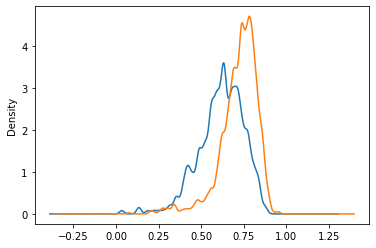

In [42]:
pd.Series(scores, index=data_val.index).groupby(data_val.is_correct).plot(
    kind='kde', bw_method=0.1,
);

In [43]:
print(roc_auc_score(data_val.is_correct, scores))

0.748492678725237


In [44]:
threshold = np.quantile(scores, 1-data_val.is_correct.mean())
print('recall@ ideal reject rate:', (scores < threshold)[data_val.is_correct.values==0].mean(), 'th:', threshold)

recall@ ideal reject rate: 0.48320413436692505 th: 0.627199889870806
